In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from joblib import Parallel, delayed
from utilities2015 import *

%matplotlib inline

In [2]:
dm = DataManager(stack='MD593', section=141, segm_params_id='tSLIC200')
# dm._load_image(format='gray')

In [3]:
segmentation = dm.load_pipeline_result('segmentation')
n_superpixels = segmentation.max() + 1

textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1
texton_hists = dm.load_pipeline_result('texHist')

neighbors = dm.load_pipeline_result('neighbors')

edge_coords = dict(dm.load_pipeline_result('edgeCoords'))
edge_neighbors = dm.load_pipeline_result('edgeNeighbors')

dedge_vectors = dm.load_pipeline_result('dedgeVectors')
dedge_neighbors = dm.load_pipeline_result('dedgeNeighbors')

In [4]:
window_size = 201
window_halfsize = (window_size-1)/2

In [5]:
sys.stderr.write('computing histogram for each pixel\n')
t = time.time()

single_channel_maps = [textonmap[dm.ymin-window_halfsize : dm.ymax+1+window_halfsize, 
                                 dm.xmin-window_halfsize : dm.xmax+1+window_halfsize] == c
                       for c in range(n_texton)]

from skimage.transform import integral_image

# it is important to pad the integral image with zeros before first row and first column
def compute_integral_image(m):
    return np.pad(integral_image(m), ((1,0),(1,0)), mode='constant', constant_values=0)

int_imgs = np.dstack(Parallel(n_jobs=4)(delayed(compute_integral_image)(m) for m in single_channel_maps))

sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

computing histogram for each pixel
done in 34.72 seconds


In [6]:
histograms = int_imgs[window_size:, window_size:] + \
            int_imgs[:-window_size, :-window_size] - \
            int_imgs[window_size:, :-window_size] - \
            int_imgs[:-window_size, window_size:]
        
histograms_normalized = histograms/histograms.sum(axis=-1)[...,None].astype(np.float)

In [7]:
dm._load_image(versions=['rgb-jpg'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
t = time.time()

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=1000)
kmeans.fit(histograms_normalized.reshape((-1, n_texton))[::10])
centroids = kmeans.cluster_centers_
# labels = kmeans.labels_	

print 'done in', time.time() - t, 'seconds'

done in 38.3310351372 seconds


In [9]:
print 'merging centroids ...',
t = time.time()

from scipy.cluster.hierarchy import fclusterdata
# cluster_assignments = fclusterdata(centroids, 1.2, method="complete", criterion="inconsistent", metric=chi2)
cluster_assignments = fclusterdata(centroids, .3, method="complete", criterion="distance", metric=chi2)

reduced_centroids = np.array([centroids[cluster_assignments == i].mean(axis=0) for i in set(cluster_assignments)])
n_reduced_texton = len(reduced_centroids)
print n_reduced_texton, 'reduced textons'

print 'done in', time.time() - t, 'seconds'

merging centroids ... 14 reduced textons
done in 0.138881921768 seconds


In [69]:
del D

In [11]:
D = np.empty((n_reduced_texton, histograms_normalized.shape[0]*histograms_normalized.shape[1]))

In [12]:
for i, c in enumerate(reduced_centroids):
    t = time.time()

    D[i] = chi2s([c], histograms_normalized.reshape((-1, n_texton)))
    
    print 'done in', time.time() - t, 'seconds'

done in 18.097892046 seconds
done in 15.0571899414 seconds
done in 15.0769541264 seconds
done in 15.0775198936 seconds
done in 15.1270990372 seconds
done in 15.1466021538 seconds
done in 15.1669487953 seconds
done in 15.1643509865 seconds
done in 15.3693399429 seconds
done in 15.1971180439 seconds
done in 15.4001061916 seconds
done in 15.3628160954 seconds
done in 15.4676198959 seconds
done in 15.3564350605 seconds


In [11]:
# H = histograms_normalized.reshape((-1, n_texton))

In [ ]:
# t = time.time()
# D = Parallel(n_jobs=4)(delayed(chi2s)([c], H) for c in reduced_centroids)
# print 'done in', time.time() - t, 'seconds'

In [52]:
np.save('labelmap2.npy', labelmap)

In [13]:
labels = np.argmin(D, axis=0)

In [18]:
label_hist = np.bincount(labels, minlength=n_reduced_texton)

In [20]:
label_hist_normalized = label_hist/float(label_hist.sum())

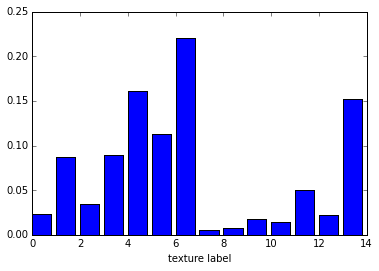

In [50]:
plt.bar(range(n_reduced_texton), label_hist_normalized);
plt.xlabel('texture label');

In [ ]:
labelmap = labels.reshape(histograms_normalized.shape[:2])

In [23]:
from skimage.measure import label, regionprops

In [61]:
comp_map, comp_num = label(labelmap, return_num=True)
props = regionprops(comp_map)
areas = np.array([p.area for p in props])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/measure/_label.py:5: DeprecationWarning: The default value for `background` will change to 0 in v0.12
  return _label(input, neighbors, background, return_num, connectivity)


In [35]:
coords = np.array([p.coords for p in props])

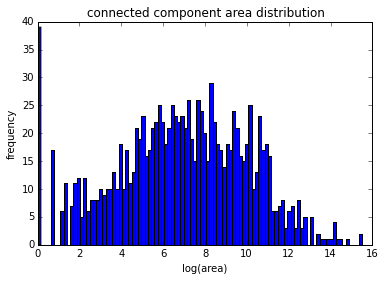

In [51]:
plt.hist(np.log(areas), bins=100);
plt.xlabel('log(area)');
plt.ylabel('frequency');
plt.title('connected component area distribution');

In [53]:
n = histograms_normalized.shape[0]*histograms_normalized.shape[1]

In [70]:
comp_num_stats = []
for i in range(100):
    random_labels = np.random.randint(0, n_reduced_texton, n)
    randommap = random_labels.reshape(histograms_normalized.shape[:2])
    _, random_comp_num = label(randommap, return_num=True)
    comp_num_stats.append(random_comp_num)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/measure/_label.py:5: DeprecationWarning: The default value for `background` will change to 0 in v0.12
  return _label(input, neighbors, background, return_num, connectivity)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/measure/_label.py:5: DeprecationWarning: The default value for `background` will change to 0 in v0.12
  return _label(input, neighbors, background, return_num, connectivity)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/measure/_label.py:5: DeprecationWarning: The default value for `background` will change to 0 in v0.12
  return _label(input, neighbors, background, return_num, connectivity)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/measure/_label.py:5: DeprecationWarning: The default value for `background` will chang

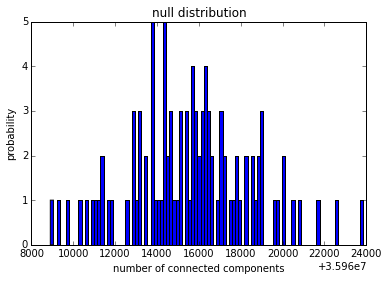

In [71]:
plt.hist(comp_num_stats, bins=100);
plt.xlabel('number of connected components');
plt.ylabel('probability');
plt.title('null distribution');

In [ ]:
plt.hist(np.log(random_areas), bins=100);
plt.xlabel('log(area)');
plt.ylabel('frequency');
plt.title('connected component area distribution');

In [ ]:
# from scipy.spatial.distance import cdist

# t = time.time()

# D = cdist(histograms_normalized.reshape((-1, n_texton)), reduced_centroids, chi2)

# # label_list = []
# # for hists in np.array_split(histograms_normalized.reshape((-1, n_texton)), 3):
# #     D = cdist(hists, reduced_centroids, chi2)
# #     labels = np.argmin(D, axis=1)
# #     label_list.append(labels)
# # labels = np.concatenate(label_list)

# print 'done in', time.time() - t, 'seconds'

In [ ]:
# kmeans = MiniBatchKMeans(n_clusters=n_reduced_texton, batch_size=1000, init=reduced_centroids, max_iter=1)
# kmeans.fit(histograms_normalized.reshape((-1, n_texton)))
# # final_centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

# print 'done in', time.time() - t, 'seconds'


In [15]:
colors = np.loadtxt('../visualization/100colors.txt')

In [16]:
viz = colors[labelmap]

In [17]:
display(viz)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg